In [1]:
import numpy as np
import mne
from mne import make_forward_solution, make_sphere_model
from mne.datasets import sample
from mne.simulation import simulate_evoked
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
import scipy.signal as signal
import os
from fooof.sim.params import param_sampler
from fooof.sim import gen_group_power_spectra, gen_power_spectrum
from Gating_Functions import extract_tapered_psd
from fooof import FOOOF
from scipy.optimize import minimize_scalar



/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_54593/2175787549.py:12: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.sim.params import param_sampler


In [ ]:
# Load the subjects raw EEG file and calculate the SNR and fooof parameters
Path = 'Path to processed files/Processed/'
index = 15

def Get_Fooof_Parameters(index, Path, channel2xtract = 128):
    ERP_files = [f for f in os.listdir(Path) if f.endswith('.set')]
    epochs = mne.read_epochs_eeglab(Path + ERP_files[index])
    epochs = epochs.crop(tmin = -.5, tmax = 1.5)
    evoked = epochs.average().get_data() 
    signal_power = np.var(evoked[channel2xtract,(epochs.times > 0) & (epochs.times < 0.4)])
    noise_power = np.var(evoked[channel2xtract,(epochs.times < 0)])  # Variance across trials & time
    snr_db = 10 * np.log10(signal_power / noise_power) # Compute SNR for each channel
    emperical_snr = snr_db

    # Fit the foof parameters to the background noise
    aperiodic_params = []
    periodic_params = []
    spectra, freqs = extract_tapered_psd(epochs, tmin=-.5, tmax=1.5, pad_duration=0)
    fm = FOOOF(peak_width_limits=[1, 15], max_n_peaks=3, aperiodic_mode='fixed')
    freq_range = [1, 30]
    for i in range(spectra.shape[0]):
        fm.fit(freqs, spectra[i,channel2xtract,:], freq_range)
        aperiodic_params.append(fm.aperiodic_params_)
        periodic_params.append(fm.peak_params_)
    return aperiodic_params, periodic_params, emperical_snr, epochs

aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(index, Path)


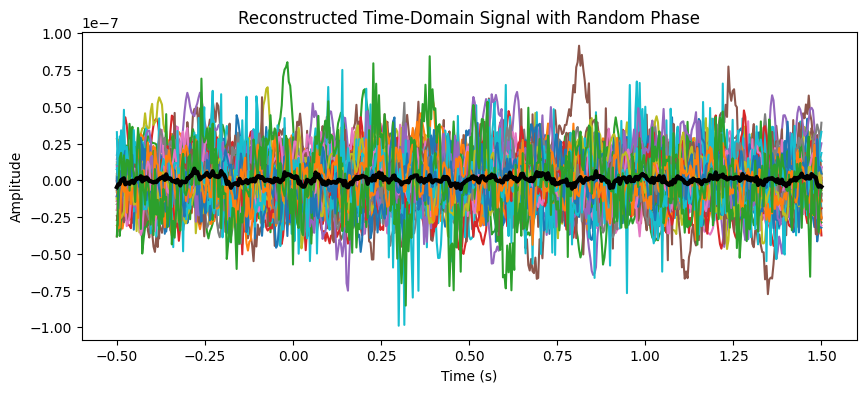

In [ ]:
# Simulate background oscillations using fooof parameters extracted from the real data

# Define simulation parameters
sfreq = epochs.info['sfreq']  # Sampling frequency (Hz)
tmin, tmax = -0.5, 1.5  # Time range (pre- and post-stimulus)
n_times = int((tmax - tmin) * sfreq) + 1  # Ensure correct length
times = np.linspace(tmin, tmax, n_times, endpoint=True)  # Generate 500 points
n_trials = len(aperiodic_params)

def Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params, periodic_params, noise_level = 0.2):
    Sim_sig_Background = np.zeros((n_trials, n_times))  # Ensure same length as time vector

    # Generate normalised background oscillations from Fooof parameters
    for ind in range(len(aperiodic_params)):

        # Generate power spectrum with correct frequency range
        freqs, powers, sim_params = gen_power_spectrum(
            [1, sfreq // 2], aperiodic_params[ind], periodic_params[ind].flatten().tolist(), 
            nlv=noise_level, freq_res=sfreq / n_times, return_params=True  # Set freq_res to match n_times
        )

        # Create random phases and construct complex spectrum
        random_phases = np.random.uniform(0, 2 * np.pi, len(powers))
        magnitudes = np.sqrt(powers)
        complex_spectrum = magnitudes * np.exp(1j * random_phases)
        
        # Construct full spectrum with correct length
        full_spectrum = np.concatenate([complex_spectrum, complex_spectrum[-2:0:-1].conj()])  # Ensure symmetry

        # Inverse FFT with explicit length
        Temp_signal = np.fft.irfft(full_spectrum, n=n_times)  # Ensure length matches n_times
        Sim_sig_Background[ind, :] = Temp_signal
        
    return Sim_sig_Background

Sim_sig_Background = Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params, periodic_params, noise_level = 0.2)

# Plot the mean signal across trials
plt.figure(figsize=(10, 4))
plt.plot(times, Sim_sig_Background.T)
plt.plot(times,np.mean(Sim_sig_Background, axis=0), 'k', linewidth=2)
plt.title("Reconstructed Time-Domain Signal with Random Phase")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

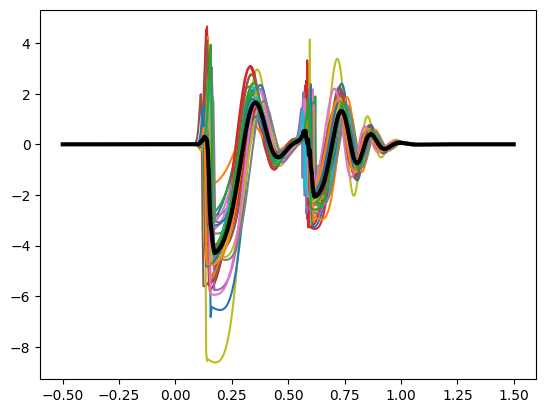

In [78]:
# Simulate the gating signal using a sine wave tapered by a gaussian
def Simulate_Signal_Sine_Wave(n_trials, n_times, times, Response_Amplitude_scaling1 = 5, Response_Amplitude_scaling2 = 2.5,
                           Ideal_latency_1 = 0.15, Ideal_latency_2 = 0.6, Latency_jitter1_scaling = 0.01, Latency_jitter2_scaling = 0.01):

    # Response frequency
    Response_Frequency = 3

    # Assymetry parameters
    sigma_rise = 0.015
    sigma_fall = 0.15

    SimulatedData = np.zeros((n_trials, n_times))
    # Generate random phase shifts
    for i in range(n_trials):

        Response1_latency = Ideal_latency_1 + Latency_jitter1_scaling * np.random.randn()
        Response2_latency = Ideal_latency_2 + Latency_jitter2_scaling * np.random.randn()

        freq_vec = np.ones(n_times) * Response_Frequency
        sigma_rise_fgaussian = 0.005  
        sigma_fall_fgaussian = 0.2

        # Create asymmetric Gaussian for the first response
        Frequency_gaussian1 = np.where(
            times < Response1_latency,
            -.9 * np.exp(-((times - Response1_latency) ** 2) / (2 * sigma_rise_fgaussian ** 2)) + 1,
            -.9 * np.exp(-((times - Response1_latency) ** 2) / (2 * sigma_fall_fgaussian ** 2)) + 1
        )

        # Create asymmetric Gaussian for the second response
        Frequency_gaussian2 = np.where(
            times < Response2_latency,
            -.9 * np.exp(-((times - Response2_latency) ** 2) / (2 * sigma_rise_fgaussian ** 2)) + 1,
            -.9 * np.exp(-((times - Response2_latency) ** 2) / (2 * sigma_fall_fgaussian ** 2)) + 1
        )
        freq_vec1 = freq_vec * Frequency_gaussian1
        freq_vec2 = freq_vec * Frequency_gaussian2

        # Define Gaussians for the tapering of amplitude
        # Define different standard deviations for rise and fall
        asym_gaussian1 = np.where(
            times < Response1_latency,
            np.exp(-((times - Response1_latency) ** 2) / (2 * sigma_rise ** 2)),  
            np.exp(-((times - Response1_latency) ** 2) / (2 * sigma_fall ** 2))  
        )

        asym_gaussian2 = np.where(
            times < Response2_latency,
            np.exp(-((times - Response2_latency) ** 2) / (2 * sigma_rise ** 2)),  
            np.exp(-((times - Response2_latency) ** 2) / (2 * sigma_fall ** 2)) )
        
        # Response phases
        random_phase1 = np.random.uniform(np.pi*1.2, 1.6*np.pi)  # Phase for first response
        random_phase2 = np.random.uniform(np.pi*1, 1.4*np.pi)  # Phase for second response

        # Response amplitudes
        Response1 = Response_Amplitude_scaling1 * np.sin(2 * np.pi * freq_vec1 * times + random_phase1) * asym_gaussian1
        Response2 = Response_Amplitude_scaling2 * np.sin(2 * np.pi * freq_vec2 * times + random_phase2) * asym_gaussian2

        SimulatedData[i,:] = Response1 + Response2
        jitter_factor = np.random.uniform(0.9, 1.1, size=(SimulatedData.shape[0], 1))  # Random scaling per trial
        SimulatedData *= jitter_factor
    return SimulatedData

Simulated_Signal = Simulate_Signal_Sine_Wave(n_trials, n_times, times)

plt.plot(times, Simulated_Signal.T)
plt.plot(times, Simulated_Signal.mean(axis=0), 'k', linewidth=3)
plt.show()


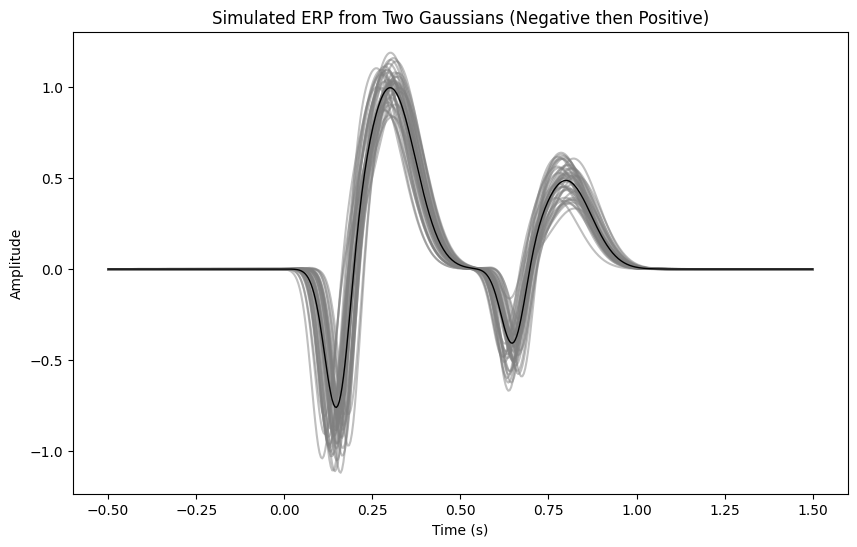

In [91]:
# Simulate the gating signal using two gaussians - This approach seems to be working best
# We have control over several important factors like latency, amplitude, width, and gating magnitude
def Simulate_Signal_from_Gaussians(n_trials, n_times, times, Gating_ratio = 0.5, 
                                latency_N1 = 0.15, latency_N2 = 0.65, 
                                sigma1 = 0.03, sigma2 = 0.07, 
                                latency_jitter = 0.015, amplitude_jitter = 0.1):

    A1 = -1
    A2 = A1 * Gating_ratio
    latency_P1 = latency_N1 + 0.15
    latency_P2 = latency_N2 + 0.15


    simulated_erp = np.zeros((n_trials, n_times))
    for trial in range(n_trials):
        # Add jitter to latencies on each trial
        trial_latency_N1 = latency_N1 + np.random.randn() * latency_jitter
        trial_latency_N2 = latency_N2 + np.random.randn() * latency_jitter
        trial_latency_P1 = latency_P1 + np.random.randn() * latency_jitter
        trial_latency_P2 = latency_P2 + np.random.randn() * latency_jitter

        trial_amplitude_N1 = A1 + np.random.randn() * amplitude_jitter
        trial_amplitude_N2 = A2 + np.random.randn() * amplitude_jitter
        trial_amplitude_P1 = -A1 + np.random.randn() * amplitude_jitter
        trial_amplitude_P2 = -A2 + np.random.randn() * amplitude_jitter
        

        erp_negative1 = trial_amplitude_N1 * np.exp(-((times - trial_latency_N1) ** 2) / (2 * sigma1 ** 2))
        erp_positive1 = trial_amplitude_P1 * np.exp(-((times - trial_latency_P1) ** 2) / (2 * sigma2 ** 2))

        erp_negative2 = trial_amplitude_N2 * np.exp(-((times - trial_latency_N2) ** 2) / (2 * sigma1 ** 2))
        erp_positive2 = trial_amplitude_P2 * np.exp(-((times - trial_latency_P2) ** 2) / (2 * sigma2 ** 2))
        
        # Sum the two components to obtain the biphasic ERP waveform
        simulated_erp[trial, :] = erp_negative1 + erp_positive1 + erp_negative2 + erp_positive2

    return simulated_erp
        

Simulated_Signal = Simulate_Signal_from_Gaussians(n_trials, n_times, times)


# Plot individual trials (gray) and the average ERP (black)
plt.figure(figsize=(10, 6))
for trial in range(n_trials):
    plt.plot(times, Simulated_Signal[trial, :], color='gray', alpha=0.5)
plt.plot(times, Simulated_Signal.mean(axis=0), 'k', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Simulated ERP from Two Gaussians (Negative then Positive)')
plt.show()

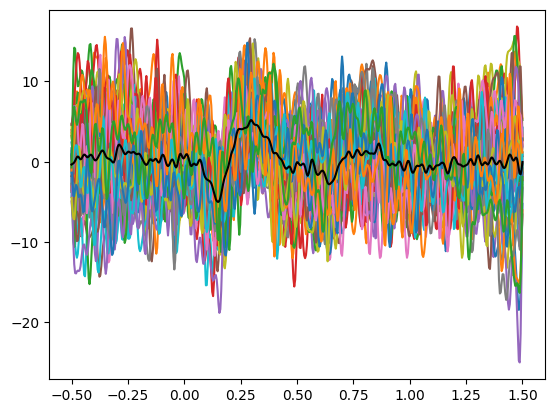

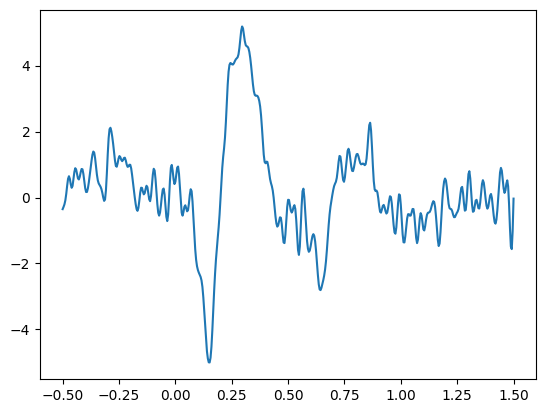

-5.000000000000001
-2.8070048836005896
8.655700634108413


In [112]:
# This function combines the gating signal with the background oscillations and scales the signal to the desired SNR
def Combine_and_Scale_Signal(Simulated_Signal, Sim_sig_Background, times, emperical_snr = emperical_snr, SNR = 'Emperical', 
                              Gaussian_noise_level = .4, N1_Amplitude = -5, desired_snr_db = 3):
    
    Sim_sig_Background = (Sim_sig_Background - np.mean(Sim_sig_Background, axis=1, keepdims=True)) / np.std(Sim_sig_Background, axis=1, keepdims=True)
    Gaussian_noise_std = Gaussian_noise_level * np.std(Sim_sig_Background, axis=1, keepdims=True)
    Gaussian_noise = np.random.normal(0, Gaussian_noise_std, size=Sim_sig_Background.shape)

    sig_start = 0
    sig_end = 1
    if SNR == 'Emperical':
        desired_snr_db = emperical_snr
        signal_var = np.var(Simulated_Signal.mean(axis=0)[(times > sig_start) & (times < sig_end)])
        background_var = np.var(Sim_sig_Background.mean(axis=0)[(times < 0)])
        snr_linear = 10 ** (desired_snr_db / 10)
        background_scaling_factor = np.sqrt(signal_var / (snr_linear * background_var))
        Sim_sig_Background = Sim_sig_Background * background_scaling_factor
        final_signal = Simulated_Signal + Sim_sig_Background + Gaussian_noise
    elif SNR == 'Paper':
        background_ERP = Sim_sig_Background.mean(axis=0)
        background_RMS = np.sqrt(np.mean(background_ERP[times < 0] ** 2))
        Signal_ERP = Simulated_Signal.mean(axis=0)
        def snr_difference(alpha):
            Full_ERP = alpha * Signal_ERP
            Signal_RMS = np.sqrt(np.mean(Full_ERP[(times > sig_start) & (times < sig_end)] ** 2))
            snr_db = 20 * np.log10(Signal_RMS/background_RMS)
            return (snr_db - desired_snr_db)**2
        result = minimize_scalar(snr_difference, bounds=(0.01, 100), method='bounded')
        alpha_opt = result.x
        print(f'The optimal alpha is {alpha_opt}')
        Scaled_signal = alpha_opt * Simulated_Signal
        final_signal = Sim_sig_Background + Scaled_signal
        final_RMS = np.sqrt(np.mean(final_signal[:, (times > sig_start) & (times < sig_end)].mean(axis=0) ** 2))
        final_signal = final_signal + Gaussian_noise
        final_RMS = np.sqrt(np.mean(final_signal[:, (times > sig_start) & (times < sig_end)].mean(axis=0) ** 2))
    elif SNR == 'Standard':
        signal_var = np.var(Simulated_Signal.mean(axis=0)[(times > sig_start) & (times < sig_end)])
        background_var = np.var(Sim_sig_Background.mean(axis=0)[(times < 0)])
        snr_linear = 10 ** (desired_snr_db / 10)
        background_scaling_factor = np.sqrt(signal_var / (snr_linear * background_var))
        Sim_sig_Background = Sim_sig_Background * background_scaling_factor
        final_signal = Simulated_Signal + Sim_sig_Background + Gaussian_noise

    # Filter the signal
    nyq_rate = sfreq / 2
    low = 0.3 / nyq_rate
    high = 35 / nyq_rate
    b, a = signal.butter(4, [low, high], btype='band')
    final_signal = signal.filtfilt(b, a, final_signal)

    emperical_peak = np.min(np.mean(final_signal[:,(times > 0) & (times < 0.2)], axis = 0))
    scaling_factor = N1_Amplitude / emperical_peak
    final_signal = final_signal * scaling_factor

    signal_rms = np.sqrt(np.mean(final_signal.mean(axis=0)[(times > sig_start) & (times < sig_end)] ** 2))
    noise_rms = np.sqrt(np.mean(final_signal.mean(axis=0)[(times < 0)] ** 2))
    snr_empirical_db = 20 * np.log10(signal_rms / noise_rms)    

    return final_signal, snr_empirical_db

Final_Signal, snr_empirical_db = Combine_and_Scale_Signal(Simulated_Signal, Sim_sig_Background, times, SNR = 'Emperical', 
                                                          Gaussian_noise_level = .9, N1_Amplitude = -5, desired_snr_db = 10)


plt.plot(times, Final_Signal.T)
plt.plot(times, Final_Signal.mean(axis=0), 'k', linewidth=1.5)
plt.show()

plt.plot(times,Final_Signal.mean(axis=0))
plt.show()
print(np.min(np.mean(Final_Signal[:,(times > 0) & (times < 0.4)], axis = 0)))
print(np.min(np.mean(Final_Signal[:,(times > .4) & (times < 0.8)], axis = 0)))
print(snr_empirical_db)

np.float64(3.0)

# Explore the use of a 2D Gaussian to modulate the amplitude in low frequencies - Inspired by the TFR of real data

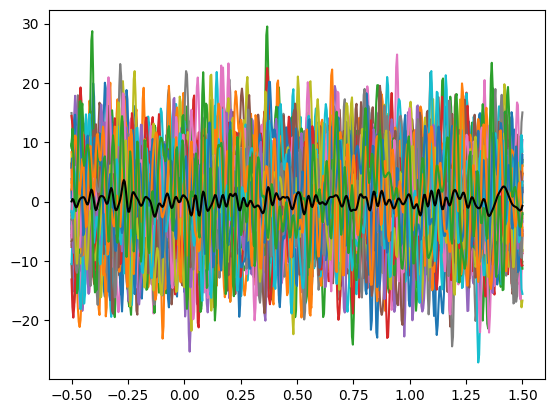

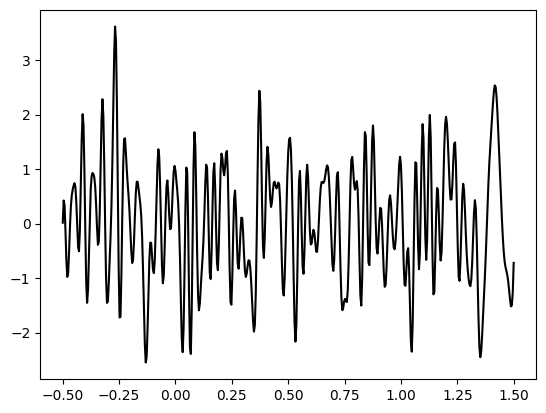

In [57]:
# Create the data using 2d gaussian for amplitude modulation
def Simulate_data_with_2D_Gaussian(n_trials, n_times, times, fmin = .1, fmax = 35, With_Amplitude_Modulation = False):
    frequencies = np.linspace(fmin, fmax, 100) 
    Frequencies, Times = np.meshgrid(frequencies, times)
    f_center1 = 2  
    t_center1 = 0.2  
    sigma_f1 = 5   
    sigma_t1 = 0.1  
    f_center2 = 2  
    t_center2 = 0.7  
    sigma_f2 = 5   
    sigma_t2 = 0.05 

    gaussian_window1 = np.exp(-(((Times - t_center1) ** 2) / (2 * sigma_t1 ** 2) +
                            ((Frequencies - f_center1) ** 2) / (2 * sigma_f1 ** 2)))
    S1_Amplitudes = gaussian_window1.T * 20
 
    gaussian_window2 = np.exp(-(((Times - t_center2) ** 2) / (2 * sigma_t2 ** 2) +
                            ((Frequencies - f_center2) ** 2) / (2 * sigma_f2 ** 2)))
    S2_Amplitudes = gaussian_window2.T * 10

    Amp_mod = S1_Amplitudes + S2_Amplitudes + 1

    # Create sine waves and modulate the amplitude with the 2D Gaussian
    sim_data = np.zeros((n_trials, len(times)))
    for i in range(n_trials):
        Temp_signal = np.zeros((len(frequencies), len(times)))
        for ind, freq in enumerate(frequencies):
            random_phase = np.random.uniform(0, np.pi*2)  # Phase for second response
            if With_Amplitude_Modulation:
                Temp_signal[ind,:] = Amp_mod[ind,:] * np.sin(2 * np.pi * freq * times + random_phase)
            else:
                Temp_signal[ind,:] = np.sin(2 * np.pi * freq * times + random_phase)
        this_trial = Temp_signal.sum(axis=0)
        sim_data[i,:] = this_trial

    return sim_data

sim_data = Simulate_data_with_2D_Gaussian(n_trials, n_times, times)

plt.plot(times, sim_data.T)
plt.plot(times, sim_data.mean(axis=0), 'k', linewidth=1.5)
plt.show()

plt.plot(times, sim_data.mean(axis=0), 'k', linewidth=1.5)
plt.show()


Extracting parameters from /Volumes/KetanData2/Processed files Thesis Pauline/Processed/GFAS_016_baseline.set...


/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_54593/3687855350.py:8: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(Path + ERP_files[index])


Not setting metadata
44 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
44 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for eeg. Disabling interactivity.


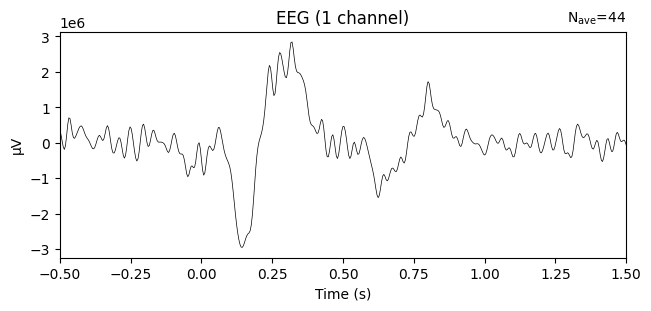

Time domain gating: 0.5238356426558387


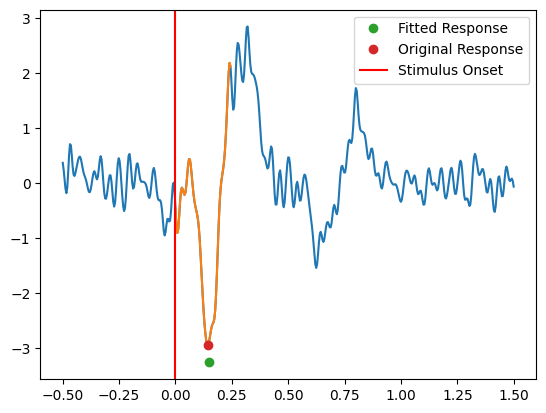

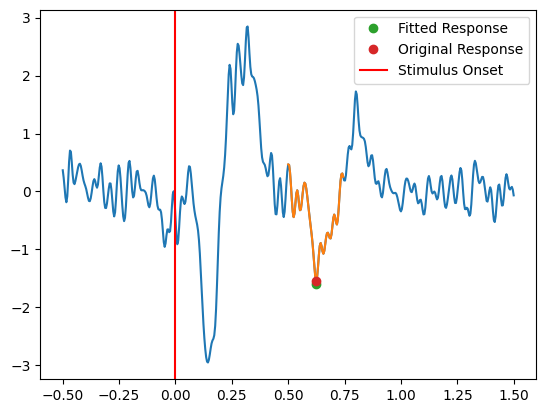

Applying baseline correction (mode: ratio)
No baseline correction applied


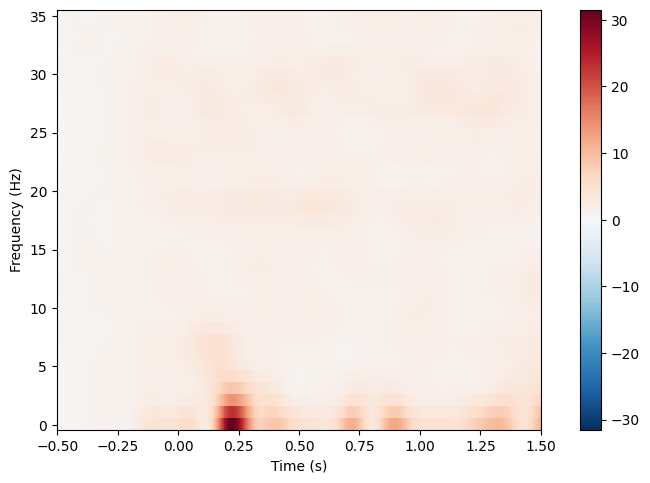

TFR gating: 0.722347243095263


In [148]:
# Skeleton of the code for the actual analysis of the simulated data

Path = 'Path to processed files/Processed/'
index = 3
aperiodic_params, periodic_params, emperical_snr, epochs = Get_Fooof_Parameters(index, Path)
epochs = epochs.crop(tmin = -.5, tmax = 1.5)
info = epochs.info
sfreq = epochs.info['sfreq']  # Sampling frequency (Hz)
tmin, tmax = -0.5, 1.5  # Time range (pre- and post-stimulus)
n_times = int((tmax - tmin) * sfreq) + 1  # Ensure correct length
times = np.linspace(tmin, tmax, n_times, endpoint=True)  # Generate 500 points
n_trials = len(aperiodic_params)

Gating_ratio = 0.5
Gaussian_noise_level = 1

Sim_sig_Background_fooof_inverse = Simulate_Background_Oscillations(n_trials, n_times, aperiodic_params,
                                                                    periodic_params, noise_level = .5)

Simulated_Signal = Simulate_Signal_from_Gaussians(n_trials, n_times, times, sigma1 = 0.03, 
                                                  sigma2 = 0.05, Gating_ratio = Gating_ratio, latency_jitter=.02, amplitude_jitter=.3)

# Make sure you correct the SNR computation in this function
Final_Signal, Final_SNR = Combine_and_Scale_Signal(Simulated_Signal, Sim_sig_Background_fooof_inverse, times, emperical_snr = emperical_snr, 
                                        SNR = 'Emperical',  Gaussian_noise_level = Gaussian_noise_level, N1_Amplitude = -3, desired_snr_db = 3)


# Save the final SNR


# Make the epochs array
Final_Signal = Final_Signal - Final_Signal[:,times<0].mean(axis = 1, keepdims = True)
Final_Signal_MNE = Final_Signal[:, np.newaxis, :]  
info = mne.create_info(ch_names=['EEG 001'], sfreq=sfreq, ch_types='eeg')  
Final_Signal_MNE = mne.EpochsArray(Final_Signal_MNE, info=info, tmin = tmin)


# Put Final Signal into MNE format
Final_Signal_MNE.average().plot(picks = 'EEG 001')
plt.show()


# Extract the peaks for N1 and N2 from the ERP
N1_time_domain = np.min(np.mean(Final_Signal, axis = 0)[(times > 0) & (times < 0.4)])
N2_time_domain = np.min(np.mean(Final_Signal, axis = 0)[(times > .5) & (times < 0.9)])
Time_domain_Gating = N2_time_domain / N1_time_domain
print(f"Time domain gating: {Time_domain_Gating}")


# Perform wavelet filtering and MLR for peak detection per trial
from Gating_Functions import perform_mlr
MLR_results_S1 = perform_mlr(Final_Signal, times, sfreq, Final_Signal, Stim_onset_sec = 0, Win_for_peak_sec=.25,
                with_intercept=False, Half_win_around_peak_sec=0.06, Artifact_offset_sec=0)
trial = 8
plt.plot(times, Final_Signal.mean(axis=0))
plt.plot(times[MLR_results_S1['Win_start']:MLR_results_S1['Win_end']], MLR_results_S1['fitted_responses'].mean(axis=0))
plt.plot(times[int(MLR_results_S1['latencies'].mean())], MLR_results_S1['peaks'].mean(), 'o', label='Fitted Response')
plt.plot(times[int(MLR_results_S1['original_latency'])], MLR_results_S1['original_peak'], 'o', label='Original Response')
plt.axvline(x = 0, color = 'r', label = 'Stimulus Onset')
plt.legend()
plt.show()

MLR_results_S2 = perform_mlr(Final_Signal, times, sfreq, Final_Signal, Stim_onset_sec = 0.5, Win_for_peak_sec=.25,
                with_intercept=False, Half_win_around_peak_sec=0.06, Artifact_offset_sec=0)

trial = 8
plt.plot(times, Final_Signal.mean(axis=0))
plt.plot(times[MLR_results_S2['Win_start']:MLR_results_S2['Win_end']], MLR_results_S2['fitted_responses'].mean(axis=0))
plt.plot(times[int(MLR_results_S2['latencies'].mean())], MLR_results_S2['peaks'].mean(), 'o', label='Fitted Response')
plt.plot(times[int(MLR_results_S2['original_latency'])], MLR_results_S2['original_peak'], 'o', label='Original Response')
plt.axvline(x = 0, color = 'r', label = 'Stimulus Onset')
plt.legend()
plt.show()

# Compute the TFR of the single trials
frequencies = np.linspace(.1, 35, 35)
n_cycles = frequencies / 2
Simulated_TFR = Final_Signal_MNE.compute_tfr(method = 'morlet', freqs = frequencies, n_cycles = n_cycles)
Simulated_TFR.apply_baseline(baseline = (None, -.2), mode = 'ratio')
Simulated_TFR.average().plot(picks = 'EEG 001')
plt.show()


# Extract the gating based on the TFR
epsilon = 1e-10
S1 = Simulated_TFR.get_data(fmin=.2, fmax=5, tmin=0, tmax=0.4, picks = 'EEG 001').mean(axis=(-1, -2))
S2 = Simulated_TFR.get_data(fmin=.2, fmax=5, tmin=.5, tmax=0.9, picks = 'EEG 001').mean(axis=(-1, -2))
TFR_gating = S2/ (S1 + epsilon)
print(f"TFR gating: {TFR_gating.mean()}")


